# Classifier Training and Testing

Before training the models, we have to do two things:
- split the data into train and val sets (see below).
- scale the data.

Then, we can train different machine learning models and evaluate the results. I have chosen to use the following algorithms:
- logistic regression.
- decision trees.
- naive Bayes.
- k-nearest neighbours.
- multi-layer perceptron.
- support vector machine.

The performance of the models will be evaluated by looking at decision matrices, as well as looking at the ROC curves (and associated area under the ROC curv

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os.path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [2]:
# Make sure we're in the right directory
correct_directory = "C:\\Users\\anear\\Desktop\\LiveScore_ML_Challenge\\LiveScore ML Challenge 4"
if os.getcwd() != correct_directory:
    os.chdir(correct_directory)
print("Current working directory: ", os.getcwd())

Current working directory:  C:\Users\anear\Desktop\LiveScore_ML_Challenge\LiveScore ML Challenge 4


In [3]:
# Load the data
_data = np.load('data/processed_dfs.npy', allow_pickle=True).tolist()
train = _data['train']
test = _data['test']
print("Loaded!")

Loaded!


In [4]:
# Show sample data in train
train.head()

,Retained,Sex,Age,FriPlay,RelPlay,HighWin,CuRank_1,CuRank_2,CuRank_3,AqChan_C,AqChan_Q,AqChan_S,AqChan_NaN
0,0,0,22.0,1,0,7.2500,0,0,1,0,0,1,0
1,1,1,38.0,1,0,71.2833,1,0,0,1,0,0,0
2,1,1,26.0,0,0,7.9250,0,0,1,0,0,1,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,0,1,0
4,0,0,35.0,0,0,8.0500,0,0,1,0,0,1,0


In [5]:
# Show sample data in test
test.head()

,Sex,Age,FriPlay,RelPlay,HighWin,CuRank_1,CuRank_2,CuRank_3,AqChan_C,AqChan_Q,AqChan_S,AqChan_NaN
0,0,34.5,0,0,7.8292,0,0,1,0,1,0,0
1,1,47.0,1,0,7.0000,0,0,1,0,0,1,0
2,0,62.0,0,0,9.6875,0,1,0,0,1,0,0
3,0,27.0,0,0,8.6625,0,0,1,0,0,1,0
4,1,22.0,1,1,12.2875,0,0,1,0,0,1,0


In [6]:
# Missing data in train set
print('No. of customers with missing data by variable (train set)')
print('')
for variable in train.columns:
    print('{}: {} ({:.1f}%)'.format(variable, sum(train[variable].isna()), 100*sum(train[variable].isna())/len(train)))

No. of customers with missing data by variable (train set)

Retained: 0 (0.0%)
Sex: 0 (0.0%)
Age: 0 (0.0%)
FriPlay: 0 (0.0%)
RelPlay: 0 (0.0%)
HighWin: 0 (0.0%)
CuRank_1: 0 (0.0%)
CuRank_2: 0 (0.0%)
CuRank_3: 0 (0.0%)
AqChan_C: 0 (0.0%)
AqChan_Q: 0 (0.0%)
AqChan_S: 0 (0.0%)
AqChan_NaN: 0 (0.0%)


In [7]:
# Missing data in test set
print('No. of customers with missing data by variable (test set)')
print('')
for variable in test.columns:
    print('{}: {} ({:.1f}%)'.format(variable, sum(test[variable].isna()), 100*sum(test[variable].isna())/len(test)))

No. of customers with missing data by variable (test set)

Sex: 0 (0.0%)
Age: 0 (0.0%)
FriPlay: 0 (0.0%)
RelPlay: 0 (0.0%)
HighWin: 0 (0.0%)
CuRank_1: 0 (0.0%)
CuRank_2: 0 (0.0%)
CuRank_3: 0 (0.0%)
AqChan_C: 0 (0.0%)
AqChan_Q: 0 (0.0%)
AqChan_S: 0 (0.0%)
AqChan_NaN: 0 (0.0%)


## Split the Data

Because our test set has no target variables (i.e. we do not know customer retention in the test set), some of the training data will need to be used to evaluate our data. We have two options for this:
- split the training set into a train and val set, where train is used to train the model and val is used to evaluate performance.
- perform k-fold cross validation.

Cross validation has the advantage of using all of the available data for training. However, I have opted here to split the data into train and val sets. The reason for this is to have a clear and fair comparison of performance across models. Because the performance of classifiers (with probabilistic outputs) is best visualised with ROC curves, I wanted to be able to plot the ROC curves of all the models together, in order to be able to quickly visually compare them. The best performing model will be retrained with all training data, and predictions will be made on the test set.

The train and val sets were created with a stratified split, in order to maintain the class balance in the two sets.

In [8]:
# Define training and target variables
X_train = np.array(train.drop('Retained', axis=1))
y_train = np.array(train['Retained'])
X_test = np.array(test)

In [9]:
# Split training set into training and val sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [10]:
# Check the shapes of the data
print('Shapes of the data')
print('')
print('X_train: {}'.format(np.shape(X_train)))
print('y_train: {}'.format(np.shape(y_train)))
print('Proportion of customers retained in test set: {:.1f}%'.format(100*sum(y_train)/len(y_train)))
print('')
print('X_val: {}'.format(np.shape(X_val)))
print('y_val: {}'.format(np.shape(y_val)))
print('Proportion of customers retained in validation set: {:.1f}%'.format(100*sum(y_val)/len(y_val)))
print('')
print('X_test: {}'.format(np.shape(X_test)))

Shapes of the data

X_train: (712, 12)
y_train: (712,)
Proportion of customers retained in test set: 38.3%

X_val: (179, 12)
y_val: (179,)
Proportion of customers retained in validation set: 38.5%

X_test: (418, 12)


## Scale the Data

In order to make training the models a smoother process, the data is scaled.

A z-transform scaler is trained on the train set, and applied to the val and test sets.

In [11]:
# Scale the training data using a z-transform, and apply that scaler to theval and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression

In [12]:
# Create logistic regression classifer object
logisticRegr = LogisticRegression(solver='liblinear')

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict customer retention in val set
y_pred = logisticRegr.predict_proba(X_val_scaled)[:,1]

In [13]:
# Write a function that plots nice confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[0][0] = round(cm[0][0],2)
        cm[0][1] = round(cm[0][1],2)
        cm[1][0] = round(cm[1][0],2)
        cm[1][1] = round(cm[1][1],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
fpr_lr, tpr_lr, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUROC for the val set
auc_lr = auc(fpr_lr, tpr_lr)

# Save TPR, FPR and AUROC to a dictionary for plotting later
results = {}
results['lr'] = [tpr_lr, fpr_lr, auc_lr]

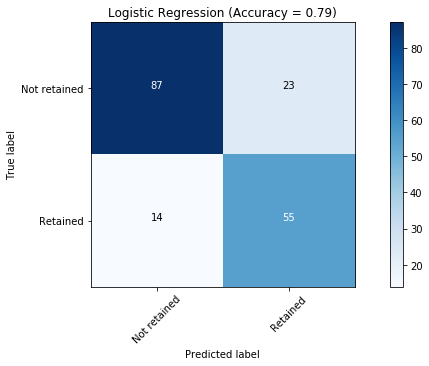

In [15]:
# Calculate the confusion matrix
decision_threshold = 0.35
cm = confusion_matrix(y_val, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='Logistic Regression (Accuracy = {:.2f})'.format(accuracy_score(y_val,y_pred>decision_threshold)))

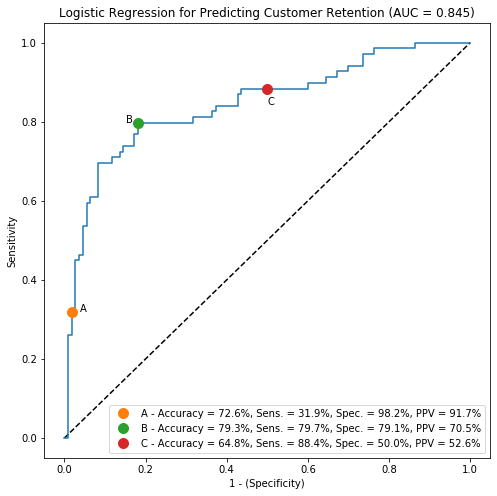

In [16]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.8, 0.35, 0.15
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_val, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_val, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_val, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_lr[A], tpr_lr[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_lr[A]+0.02, tpr_lr[A]))
plt.plot(fpr_lr[B], tpr_lr[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_lr[B]-0.03, tpr_lr[B]))
plt.plot(fpr_lr[C], tpr_lr[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_lr[C], tpr_lr[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Logistic Regression for Predicting Customer Retention (AUC = {:.3f})'.format(auc_lr))
plt.legend(loc='lower right')
plt.show()

In [17]:
# Look at how variables are weighted in logistic regression model
print('Weights for logistic regression model')
print('')
for i in range(np.shape(X_train)[1]):
    print('{}: {:.2f}'.format(train.columns[i+1], logisticRegr.coef_[0][i]))

Weights for logistic regression model

Sex: 1.25
Age: -0.59
FriPlay: -0.35
RelPlay: -0.06
HighWin: 0.09
CuRank_1: 0.56
CuRank_2: 0.08
CuRank_3: -0.55
AqChan_C: 0.03
AqChan_Q: 0.13
AqChan_S: -0.13
AqChan_NaN: 0.19


## Decision Trees

In [18]:
# Create decision tree classifer object
decisionTree = DecisionTreeClassifier(random_state=42)

# Train decision tree classifer
decisionTree.fit(X_train_scaled, y_train)

# Predict customer retention in val set
y_pred = decisionTree.predict_proba(X_val_scaled)[:,1]

In [19]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
fpr_dt, tpr_dt, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUROC for the val set
auc_dt = auc(fpr_dt, tpr_dt)

# Save TPR, FPR and AUROC to a dictionary for plotting later
results['dt'] = [tpr_dt, fpr_dt, auc_dt]

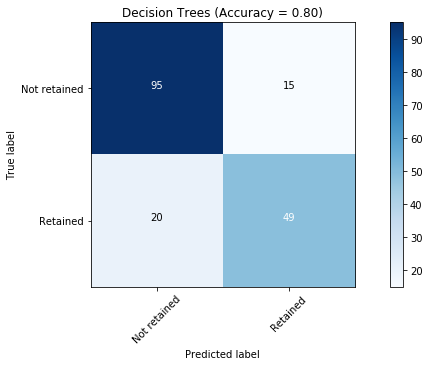

In [20]:
# Calculate the confusion matrix
decision_threshold = 0.5
cm = confusion_matrix(y_val, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='Decision Trees (Accuracy = {:.2f})'.format(accuracy_score(y_val,y_pred>decision_threshold)))

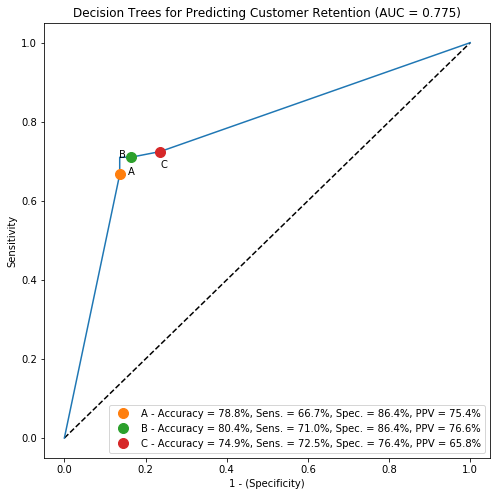

In [21]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.99, 0.5, 0.05
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_val, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_val, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_val, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt)
plt.plot(fpr_dt[A], tpr_dt[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_dt[A]+0.02, tpr_dt[A]))
plt.plot(fpr_dt[B], tpr_dt[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_dt[B]-0.03, tpr_dt[B]))
plt.plot(fpr_dt[C], tpr_dt[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_dt[C], tpr_dt[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Decision Trees for Predicting Customer Retention (AUC = {:.3f})'.format(auc_dt))
plt.legend(loc='lower right')
plt.show()

## Naive Bayes

In [22]:
# Create naive Bayes classifer object
naiveBayes = GaussianNB()

# Train naive Bayes classifer
naiveBayes.fit(X_train_scaled, y_train)

# Predict customer retention in val set
y_pred = naiveBayes.predict_proba(X_val_scaled)[:,1]

In [23]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
fpr_nb, tpr_nb, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUROC for the val set
auc_nb = auc(fpr_nb, tpr_nb)

# Save TPR, FPR and AUROC to a dictionary for plotting later
results['nb'] = [tpr_nb, fpr_nb, auc_nb]

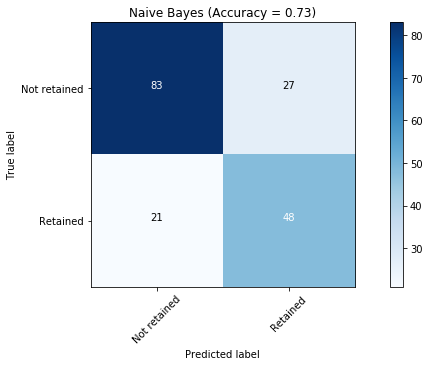

In [24]:
# Calculate the confusion matrix
decision_threshold = 0.00001
cm = confusion_matrix(y_val, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='Naive Bayes (Accuracy = {:.2f})'.format(accuracy_score(y_val,y_pred>decision_threshold)))

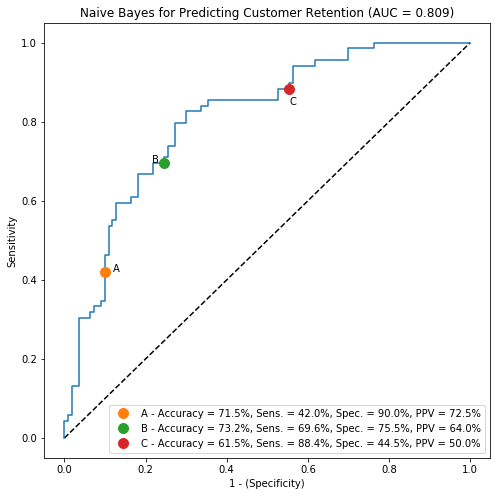

In [25]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.0001, 0.00001, 0.000001
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_val, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_val, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_val, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb)
plt.plot(fpr_nb[A], tpr_nb[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_nb[A]+0.02, tpr_nb[A]))
plt.plot(fpr_nb[B], tpr_nb[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_nb[B]-0.03, tpr_nb[B]))
plt.plot(fpr_nb[C], tpr_nb[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_nb[C], tpr_nb[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Naive Bayes for Predicting Customer Retention (AUC = {:.3f})'.format(auc_nb))
plt.legend(loc='lower right')
plt.show()

## k-Nearest Neighbours

In [26]:
# Create k-nearest neighbours classifer object
kNN = KNeighborsClassifier()

# Train k-nearest neighbours classifer
kNN.fit(X_train_scaled, y_train)

# Predict customer retention in val set
y_pred = kNN.predict_proba(X_val_scaled)[:,1]

In [27]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
fpr_knn, tpr_knn, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUROC for the val set
auc_knn = auc(fpr_knn, tpr_knn)

# Save TPR, FPR and AUROC to a dictionary for plotting later
results['knn'] = [tpr_knn, fpr_knn, auc_knn]

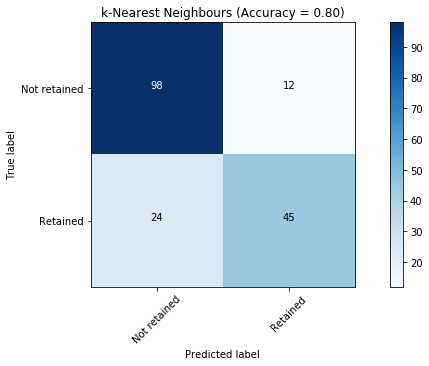

In [28]:
# Calculate the confusion matrix
decision_threshold = 0.4
cm = confusion_matrix(y_val, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='k-Nearest Neighbours (Accuracy = {:.2f})'.format(accuracy_score(y_val,y_pred>decision_threshold)))

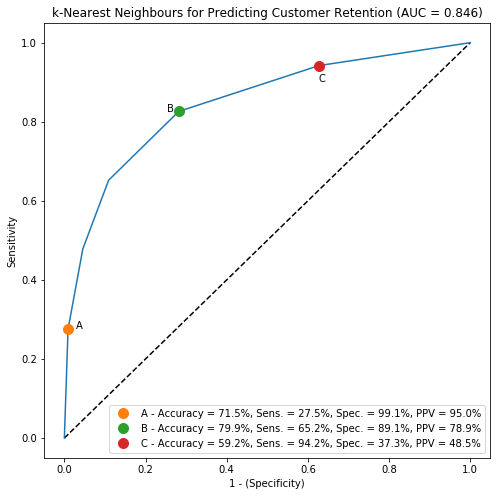

In [29]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.9, 0.4, 0.1
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_val, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_val, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_val, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn)
plt.plot(fpr_knn[A], tpr_knn[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_knn[A]+0.02, tpr_knn[A]))
plt.plot(fpr_knn[B], tpr_knn[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_knn[B]-0.03, tpr_knn[B]))
plt.plot(fpr_knn[C], tpr_knn[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_knn[C], tpr_knn[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('k-Nearest Neighbours for Predicting Customer Retention (AUC = {:.3f})'.format(auc_knn))
plt.legend(loc='lower right')
plt.show()

## Multi-Layer Perceptron

In [30]:
# Create neural network classifer object
neuralNet = MLPClassifier(random_state=42, max_iter=1000)

# Train decision tree classifer
neuralNet.fit(X_train_scaled, y_train)

# Predict customer retention in val set
y_pred = neuralNet.predict_proba(X_val_scaled)[:,1]

In [31]:
# Calculate TPR and FPR on the val set for plotting the ROC curve
fpr_mlp, tpr_mlp, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUROC for the val set
auc_mlp = auc(fpr_mlp, tpr_mlp)

# Save TPR, FPR and AUROC to a dictionary for plotting later
results['mlp'] = [tpr_mlp, fpr_mlp, auc_mlp]

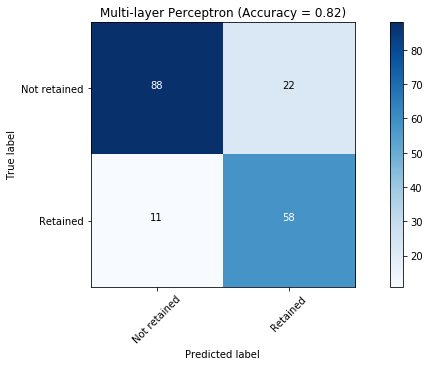

In [32]:
# Calculate the confusion matrix
decision_threshold = 0.3
cm = confusion_matrix(y_val, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='Multi-Layer Perceptron (Accuracy = {:.2f})'.format(accuracy_score(y_val,y_pred>decision_threshold)))

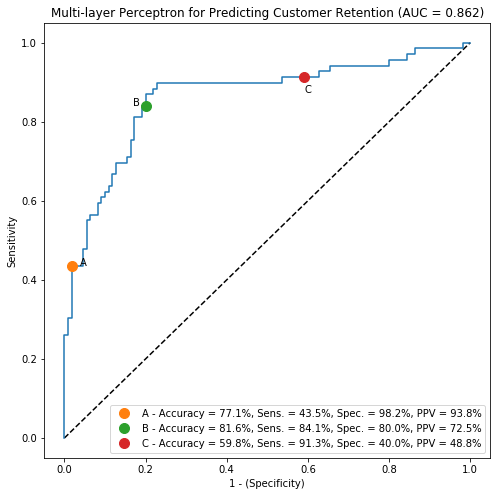

In [33]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.9, 0.3, 0.1
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_val, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_val, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_val, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp)
plt.plot(fpr_mlp[A], tpr_mlp[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_mlp[A]+0.02, tpr_mlp[A]))
plt.plot(fpr_mlp[B], tpr_mlp[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_mlp[B]-0.03, tpr_mlp[B]))
plt.plot(fpr_mlp[C], tpr_mlp[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_mlp[C], tpr_mlp[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Multi-Layer Perceptron for Predicting Customer Retention (AUC = {:.3f})'.format(auc_mlp))
plt.legend(loc='lower right')
plt.show()

## Support Vector Machine

In [34]:
# Create support vector classifer object
supportVector = SVC(probability=True)

# Train support vector classifer
supportVector.fit(X_train_scaled, y_train)

# Predict customer retention in val set
y_pred = supportVector.predict_proba(X_val_scaled)[:,1]

In [35]:
# Calculate TPR and FPR on the val set for plotting the ROC curve
fpr_svc, tpr_svc, thresholds = roc_curve(y_val, y_pred)

# Calculate the AUROC for the val set
auc_svc = auc(fpr_svc, tpr_svc)

# Save TPR, FPR and AUROC to a dictionary for plotting later
results['svc'] = [tpr_svc, fpr_svc, auc_svc]

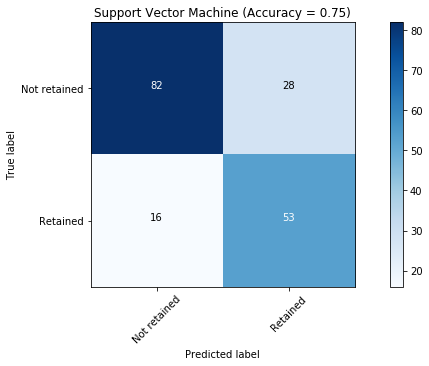

In [36]:
# Calculate the confusion matrix
decision_threshold = 0.2
cm = confusion_matrix(y_val, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='Support Vector Machine (Accuracy = {:.2f})'.format(accuracy_score(y_val,y_pred>decision_threshold)))

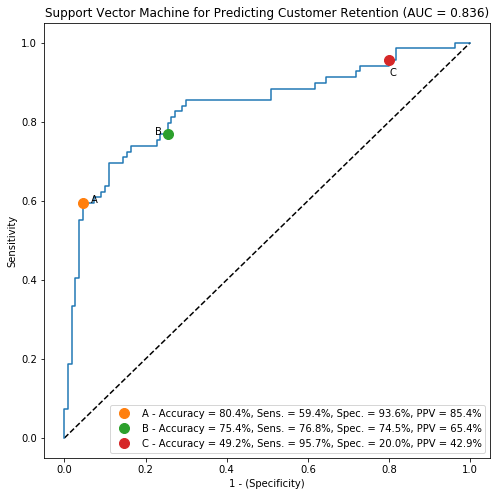

In [37]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.6, 0.2, 0.16
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_val, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_val, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_val, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svc, tpr_svc)
plt.plot(fpr_svc[A], tpr_svc[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_svc[A]+0.02, tpr_svc[A]))
plt.plot(fpr_svc[B], tpr_svc[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_svc[B]-0.03, tpr_svc[B]))
plt.plot(fpr_svc[C], tpr_svc[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_svc[C], tpr_svc[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Support Vector Machine for Predicting Customer Retention (AUC = {:.3f})'.format(auc_svc))
plt.legend(loc='lower right')
plt.show()

# Compare the Performance of All Models

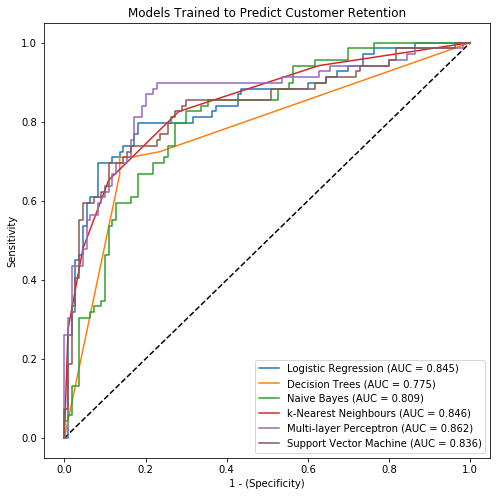

In [39]:
# Create a dictionary with the names of the models for the legend below
models = {
    'lr': 'Logistic Regression',
    'dt': 'Decision Trees',
    'nb': 'Naive Bayes',
    'knn': 'k-Nearest Neighbours',
    'mlp': 'Multi-layer Perceptron',
    'svc': 'Support Vector Machine'
}

# Iterature over the results to plot ROC curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
for model in results:
    plt.plot(results[model][1], results[model][0], label='{} (AUC = {:.3f})'.format(models[model], results[model][2]))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Models Trained to Predict Customer Retention')
plt.legend(loc='lower right')
plt.show()

# Retraining the MLP Classifier and Making Predictions

As seen above, the MLP classifier is the best performing of the models above. This model will be retrained with all available training data. Predictions will then be made for the test set.

In [46]:
# Define training and target variables
X_train = np.array(train.drop('Retained', axis=1))
y_train = np.array(train['Retained'])
X_test = np.array(test)

In [47]:
# Scale the training data using a z-transform, and apply that scaler to theval and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
# Create neural network classifer object
neuralNet = MLPClassifier(random_state=42, max_iter=1000)

# Train decision tree classifer
neuralNet.fit(X_train_scaled, y_train)

# Predict customer retention in train set
y_pred = neuralNet.predict_proba(X_train_scaled)[:,1]

In [53]:
# Calculate TPR and FPR on the val set for plotting the ROC curve
fpr_mlp1, tpr_mlp1, thresholds = roc_curve(y_train, y_pred)

# Calculate the AUROC for the val set
auc_mlp1 = auc(fpr_mlp1, tpr_mlp1)

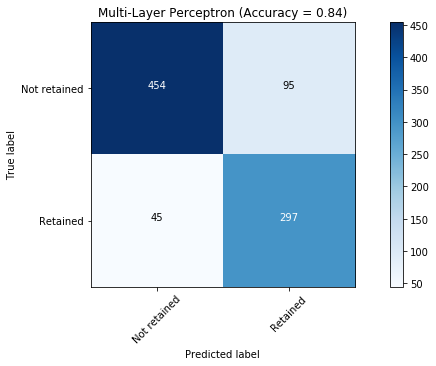

In [63]:
# Calculate the confusion matrix
decision_threshold = 0.3
cm = confusion_matrix(y_train, y_pred[:]>decision_threshold)
plot_confusion_matrix(cm, ['Not retained', 'Retained'], normalize=False, title='Multi-Layer Perceptron (Accuracy = {:.2f})'.format(accuracy_score(y_train,y_pred>decision_threshold)))

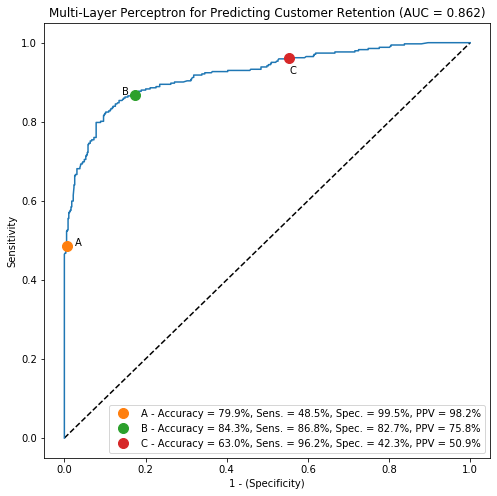

In [62]:
# Choose the three thresholds
thresh_A, thresh_B, thresh_C = 0.9, 0.3, 0.1
A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_train, y_pred[:]>thresh_A)
[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_train, y_pred[:]>thresh_B)
[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_train, y_pred[:]>thresh_C)

# Plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp1, tpr_mlp1)
plt.plot(fpr_mlp1[A], tpr_mlp1[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
plt.annotate('A', (fpr_mlp1[A]+0.02, tpr_mlp1[A]))
plt.plot(fpr_mlp1[B], tpr_mlp1[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
plt.annotate('B', (fpr_mlp1[B]-0.03, tpr_mlp1[B]))
plt.plot(fpr_mlp1[C], tpr_mlp1[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
plt.annotate('C', (fpr_mlp1[C], tpr_mlp1[C]-0.04))
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Multi-Layer Perceptron for Predicting Customer Retention (AUC = {:.3f})'.format(auc_mlp))
plt.legend(loc='lower right')
plt.show()

In [72]:
# Make predictions for test set
decision_threshold = 0.3
y_pred = neuralNet.predict_proba(X_test_scaled)[:,1]
final_predictions = neuralNet.predict_proba(X_test_scaled)[:,1] > decision_threshold

# Add final predictions to pandas dataframe
test['RetentionPrediction'] = final_predictions*1
test.head()

,Sex,Age,FriPlay,RelPlay,HighWin,CuRank_1,CuRank_2,CuRank_3,AqChan_C,AqChan_Q,AqChan_S,AqChan_NaN,RetentionPrediction
0,0,34.5,0,0,7.8292,0,0,1,0,1,0,0,0
1,1,47.0,1,0,7.0000,0,0,1,0,0,1,0,1
2,0,62.0,0,0,9.6875,0,1,0,0,1,0,0,0
3,0,27.0,0,0,8.6625,0,0,1,0,0,1,0,0
4,1,22.0,1,1,12.2875,0,0,1,0,0,1,0,0
